# Experiments analysis

## Dependencies

In [1]:
import json
import msgpack
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 200

/tmp/ipykernel_6496/436481199.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Variables

In [2]:
base_dir = "logs"

last_step = 3600

variations = [
    "nodes=100;unique_images=08",
    "nodes=100;unique_images=32",
    "nodes=196;unique_images=16",
    "nodes=196;unique_images=64",
]

logs = [
    ("central", "central;{variation}"),
    ("community", "community12p;{variation}"),
    ("community", "community25p;{variation}"),
    ("p2p", "p2p;{variation}"),
    ("dynamic", "p2p;{variation}"),
    ("resource_aware_dynamic", "p2p;{variation}", "1"),
    ("resource_aware_dynamic", "p2p;{variation}", "2"),
    ("resource_aware_dynamic", "p2p;{variation}", "3"),
    ("resource_aware_dynamic", "p2p;{variation}", "4"),
]

seed = "1"

algorithm_map = {
    "central": "Central",
    "community": "Comm.",
    "p2p": "P2P",
    "dynamic": "LM Dyn.",
    "resource_aware_dynamic": "RR Dyn.",
}

algorithm_labels = ["Central", "Comm. (12%)", "Comm. (25%)", "P2P", "LM Dyn.", "RR Dyn. (1)", "RR Dyn. (2)", "RR Dyn. (3)", "RR Dyn. (4)"]

## Base functions

### Latency

In [3]:
def get_latency_data(variation, user_type=None):
    user_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Mean": 0,
        }

        # Opening file
        user_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/User.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/User.msgpack"
        )
        user_file = open(user_msgpack_file, "rb")
        user_msgpack = msgpack.load(user_file)
        user_df = pd.DataFrame(user_msgpack)

        # Collecting information
        latency = (
            user_df[["Object", "Delays"]]
            if user_type is None
            else user_df[user_df["User Type"] == user_type][["Object", "Delays"]]
        )

        # Persisting information
        simulation_data["Delays"] = latency["Delays"]
        simulation_data["Mean"] = latency["Delays"].mean()

        # Closing file
        user_file.close()

        # Appending data
        user_data.append(simulation_data)

    return pd.DataFrame(user_data)

### Provisioning Time

In [4]:
def get_provisioning_time_data(step, variation):
    service_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Prov. Time Values": [],
            "Mean": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_duration = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)

        # Persisting information
        simulation_data["Prov. Time Values"] = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)
        simulation_data["Mean"] = migrations_duration.mean()

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

### Service Reallocations

In [5]:
def get_reallocations_data(step, variation):
    service_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Only Using Cache": 0,
            "Partially Using Cache": 0,
            "Not Using Cache": 0,
            "Total Migrations": 0,
            "Only Using Cache (%)": 0,
            "Partially Using Cache (%)": 0,
            "Not Using Cache (%)": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_last_step = service_df[service_df["Time Step"] == step][["Object", "Migrations (Only Cache)", "Migrations (Partial Cache)", "Migrations (No Cache)"]]

        # Persisting information
        simulation_data["Only Using Cache"] = migrations_last_step["Migrations (Only Cache)"].sum()
        simulation_data["Partially Using Cache"] = migrations_last_step["Migrations (Partial Cache)"].sum()
        simulation_data["Not Using Cache"] = migrations_last_step["Migrations (No Cache)"].sum()
        simulation_data["Total Migrations"] = simulation_data["Only Using Cache"] + simulation_data["Partially Using Cache"] + simulation_data["Not Using Cache"]
        simulation_data["Only Using Cache (%)"] = simulation_data["Only Using Cache"] / simulation_data["Total Migrations"]
        simulation_data["Partially Using Cache (%)"] = simulation_data["Partially Using Cache"] / simulation_data["Total Migrations"]
        simulation_data["Not Using Cache (%)"] = simulation_data["Not Using Cache"] / simulation_data["Total Migrations"]

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

### Registry Usage

In [53]:
def get_registry_usage_data(variation):
    registry_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Values": [],
            "Values (w/o 0%)": [],
            "Mean": 0,
            "Mean Provisioned": 0,
        }

        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registry_filtered_data = (
            registry_df[registry_df["P2P"] == True][["Object", "Provisioning", "Not Provisioning"]]
            if log[1] == "p2p"
            else registry_df[["Object", "Provisioning", "Not Provisioning"]]
        )
        registry_data_grouped = registry_filtered_data.groupby("Object").sum()
        registry_data_grouped["Total Steps"] = registry_data_grouped.sum(axis=1)
        registry_data_grouped["Provisioning Percentage"] = registry_data_grouped["Provisioning"] / registry_data_grouped["Total Steps"]
        registry_data_grouped["Not Provisioning Percentage"] = registry_data_grouped["Not Provisioning"] / registry_data_grouped["Total Steps"]

        # Persisting information
        simulation_data["Values"] = registry_data_grouped["Provisioning Percentage"]
        simulation_data["Values (w/o 0%)"] = registry_data_grouped[registry_data_grouped["Provisioning Percentage"] > 0]["Provisioning Percentage"]
        simulation_data["Mean"] = registry_data_grouped["Provisioning Percentage"].mean()
        simulation_data["Mean Provisioned"] = registry_data_grouped["Total Steps"].sum() / last_step
        

        # Closing file
        registry_file.close()

        # Appending data
        registry_data.append(simulation_data)

    return pd.DataFrame(registry_data)

### Number of Registries per Time Step

In [7]:
def get_number_of_registries_data(variation):
    registry_data = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registries_per_timestep = registry_df[registry_df["Time Step"] > 0].groupby(["Time Step"]).count()["Object"]

        # Persisting information
        registry_data[algorithm_labels[index]] = registries_per_timestep

        # Closing file
        registry_file.close()

    registries_per_timestep_df = pd.concat(registry_data, axis=1)

    return registries_per_timestep_df

### Server Utilization per Time Step

In [8]:
def normalize_cpu_and_memory(cpu, memory) -> float:
    """Normalizes the CPU and memory values.

    Args:
        cpu (float): CPU value.
        memory (float): Memory value.

    Returns:
        normalized_value (float): Normalized value.
    """
    normalized_value = (cpu * memory) ** (1 / 2)
    return normalized_value
    
def get_server_utilization_data(variation):
    server_data = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)
        
        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "CPU", "RAM", "CPU Demand", "RAM Demand", "Time Step"]]
        server_df["Normalized Utilization"] = server_df.apply(lambda row: normalize_cpu_and_memory(row["CPU Demand"], row["RAM Demand"])/normalize_cpu_and_memory(row["CPU"], row["RAM"]), axis=1)
        
        server_per_timestep = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Normalized Utilization"].mean()

        # Persisting information
        server_data[algorithm_labels[index]] = server_per_timestep

        # Closing file
        server_file.close()

    return pd.concat(server_data, axis=1)

### Image Replication per Time Step

In [9]:
def get_image_replication_data(log, variation):
    # Formatting log
    log = list(log)
    log[1] = log[1].format(variation=variation)
    
    # Opening file
    topology_msgpack_file = (
        f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Topology.msgpack"
        if len (log) == 2
        else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Topology.msgpack"
    )
    topology_file = open(topology_msgpack_file, "rb")
    topology_msgpack = msgpack.load(topology_file, strict_map_key=False)
    topology_df = pd.DataFrame(topology_msgpack)

    # Collecting information
    image_replication_data = topology_df[["Object", "Replication Data", "Time Step"]]
    image_replication_data = pd.json_normalize(image_replication_data["Replication Data"]).fillna(0)
    image_replication_data = image_replication_data.divide(image_replication_data.sum(axis=1), axis=0)

    # Sort headers
    image_replication_data = image_replication_data.reindex(sorted(image_replication_data.columns), axis=1)

    # Closing file
    topology_file.close()

    return image_replication_data

### Disk Occupation

In [54]:
   
def get_total_disk_utilization_data(variation):
    server_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Total Disk Occupation": 0,
            "Mean Disk Occupation per Server": 0,
        }

        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "Disk Demand"]]
        number_of_unique_servers = server_df["Object"].nunique()

        # Persisting information
        simulation_data["Total Disk Occupation"] = server_df["Disk Demand"].sum()
        simulation_data["Mean Disk Occupation per Server"] = simulation_data["Total Disk Occupation"] / (number_of_unique_servers * 3600)

        # Closing file
        server_file.close()

        # Appending data
        server_data.append(simulation_data)

    return pd.DataFrame(server_data)

### Disk Occupation per Time Step

In [48]:
   
def get_disk_utilization_data(variation):
    server_data = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)
        
        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "Disk Demand", "Time Step"]]
        
        server_per_timestep = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Disk Demand"].sum()

        # Persisting information
        server_data[algorithm_labels[index]] = server_per_timestep

        # Closing file
        server_file.close()

    return pd.concat(server_data, axis=1)

### Utilitary

In [12]:
def customize_chart(
    ax,
    title: dict = {},
    xticklabels: dict = {},
    xlabel: dict = {},
    yticklabels: dict = {},
    ylabel: str = {},
    legend: dict = {},
):
    """Customizes the chart.
    
    Args:
        ax (matplotlib.axes.Axes): Axes object.
        title (str): Chart title.
        xticklabels (list): List of xtick labels.
        xlabel (str): Label of the x axis.
        yticklabels (list): List of ytick labels.
        ylabel (str): Label of the y axis.
        legend_labels (list): List of legend labels.
    """
    if title != {}:
        ax.set_title(**title)

    if xticklabels != {}:
        ax.set_xticklabels(**xticklabels)
    
    if xlabel != {}:
        ax.set_xlabel(**xlabel)

    if yticklabels != {}:
        ax.set_yticklabels(**yticklabels)

    if ylabel != {}:
        ax.set_ylabel(**ylabel)

    if legend != {}:
        ax.legend(**legend)

In [13]:
def calculate_relative_difference(data, key):
    data = data.reset_index(drop=True)
    data["Central"] = data[key] / data[key][0]
    data["Comm (12%)"] = data[key] / data[key][1]
    data["Comm (25%)"] = data[key] / data[key][2]
    data["P2P"] = data[key] / data[key][3]

    return data

In [61]:
base_string_portrait = """
\\begin{table}
\centering
\caption{%(caption)s}
\label{%(label)s}
%(table)s
\end{table}
"""

base_string_landscape = """
\\afterpage{\clearpage
\\begin{landscape}
\\begin{table}
\centering
\caption{%(caption)s}
\label{%(label)s}
%(table)s
\end{table}
\end{landscape}
}
"""

def create_grid_of_latex_tables(tables_grid: dict, caption: str, label: str, text_size: str, orientation: str = "portrait"):
    base_string = base_string_portrait if orientation == "portrait" else base_string_landscape

    grid = ""
    for row in tables_grid:
        for column in row:
            column_size = 1 / len(row)
            grid += f"\\begin{{minipage}}[t]{{{column_size}\\linewidth}}\n\\centering\n\\{text_size}{{{column}}}\\end{{minipage}}"
        grid += "\n\\hfill\n" if orientation == "portrait" else "\n\\vfill\n"

    table = base_string % {"caption": caption, "label": label, "table": grid}

    return table


## Experiments Description

### Container Images

/tmp/ipykernel_6496/3801615395.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(**xticklabels)
/tmp/ipykernel_6496/3801615395.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(**yticklabels)


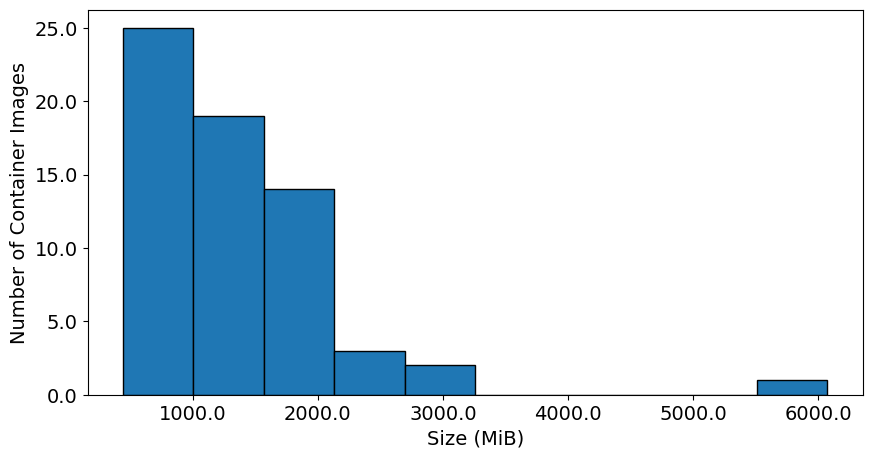

In [15]:
# Loading container images metadata
container_images = json.load(open("datasets/inputs/templates/container_images.json", "r"))

# Ignoring registry image
container_images = container_images[1:]

# Collecting size of images
image_sizes = [sum([layer["size"] for layer in image["layers"]])/1000000 for image in container_images]

# Plot size distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(image_sizes, bins=10, edgecolor="black")

# Customizing chart
font_dict = {
    "fontsize": 14
}
xticklabels = {
    "labels": ax.get_xticks(),
    "fontdict": font_dict
}
x_label = {
    "xlabel": "Size (MiB)",
    "fontdict": font_dict
}
yticklabels = {
    "labels": ax.get_yticks(),
    "fontdict": font_dict
}
y_label = {
    "ylabel": "Number of Container Images",
    "fontdict": font_dict
}
customize_chart(ax, xticklabels=xticklabels, xlabel=x_label, yticklabels=yticklabels, ylabel=y_label)

# Saving figure
plt.savefig(f"image_size_distribution.pdf", bbox_inches='tight')

## Results

### Latency

In [16]:
latency_dfs = {
    variation: get_latency_data(variation)
    for variation in variations
}

#### Comparative Table

In [73]:
latency_tables = {}

for key, latency_df in latency_dfs.items():
    #latency_df_table = calculate_relative_difference(latency_df, "Mean")
    #latency_df_table = latency_df_table[["Algorithm", "Mean", "Central", "Comm (12%)", "Comm (25%)", "P2P"]]
    latency_df_table = latency_df[["Algorithm", "Mean"]]
    latency_df_table.to_csv(f"{base_dir}/latency;{key}.csv", index=False, sep=";", decimal=",")
    latency_tables[key] = latency_df_table

latency_tables_grid = [
    [
        latency_tables[variations[0]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=100;unique_images=32} \\\\\n\\toprule"),
        latency_tables[variations[1]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=100;unique_images=08} \\\\\n\\toprule"),
    ],
    [
        latency_tables[variations[2]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=196;unique_images=64} \\\\\n\\toprule"),
        latency_tables[variations[3]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=196;unique_images=16} \\\\\n\\toprule"),
    ]
]

latency_tables_grid_latex_string = create_grid_of_latex_tables(latency_tables_grid, "Latency comparison between algorithms in multiple scenarios.", "tab:latency", "footnotesize", "portrait").replace("%", "\%").replace("_", "\_")

with open(f"{base_dir}/latency_tables.tex", "w") as f:
    f.write(latency_tables_grid_latex_string)

### Provisioning Time

In [18]:
provisioning_time_dfs = {
    variation: get_provisioning_time_data(last_step, variation)
    for variation in variations
}

#### Comparative Table

In [74]:
provisioning_time_tables = {}

for key, provisioning_time_df in provisioning_time_dfs.items():
    #provisioning_time_table = calculate_relative_difference(provisioning_time_df, "Mean")
    #provisioning_time_table = provisioning_time_table[["Algorithm", "Mean", "Central", "Comm (12%)", "Comm (25%)", "P2P"]]
    provisioning_time_table = provisioning_time_df[["Algorithm", "Mean"]]
    provisioning_time_table.to_csv(f"{base_dir}/provisioning_time;{key}.csv", index=False, sep=";", decimal=",")
    provisioning_time_tables[key] = provisioning_time_table

provisioning_time_tables_grid = [
    [
        provisioning_time_tables[variations[0]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=100;unique_images=32} \\\\\n\\toprule"),
        provisioning_time_tables[variations[1]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=100;unique_images=08} \\\\\n\\toprule"),
    ],
    [
        provisioning_time_tables[variations[2]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=196;unique_images=64} \\\\\n\\toprule"),
        provisioning_time_tables[variations[3]].to_latex(index=False, escape=False, column_format="lc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{2}{c}{nodes=196;unique_images=16} \\\\\n\\toprule"),
    ]
]

provisioning_time_tables_grid_latex_string = create_grid_of_latex_tables(provisioning_time_tables_grid, "Provisioning time comparison between algorithms in multiple scenarios.", "tab:provisioning-time", "footnotesize", "portrait").replace("%", "\%").replace("_", "\_")

with open(f"{base_dir}/provisioning_time_tables.tex", "w") as f:
    f.write(provisioning_time_tables_grid_latex_string)

#### CDF Chart

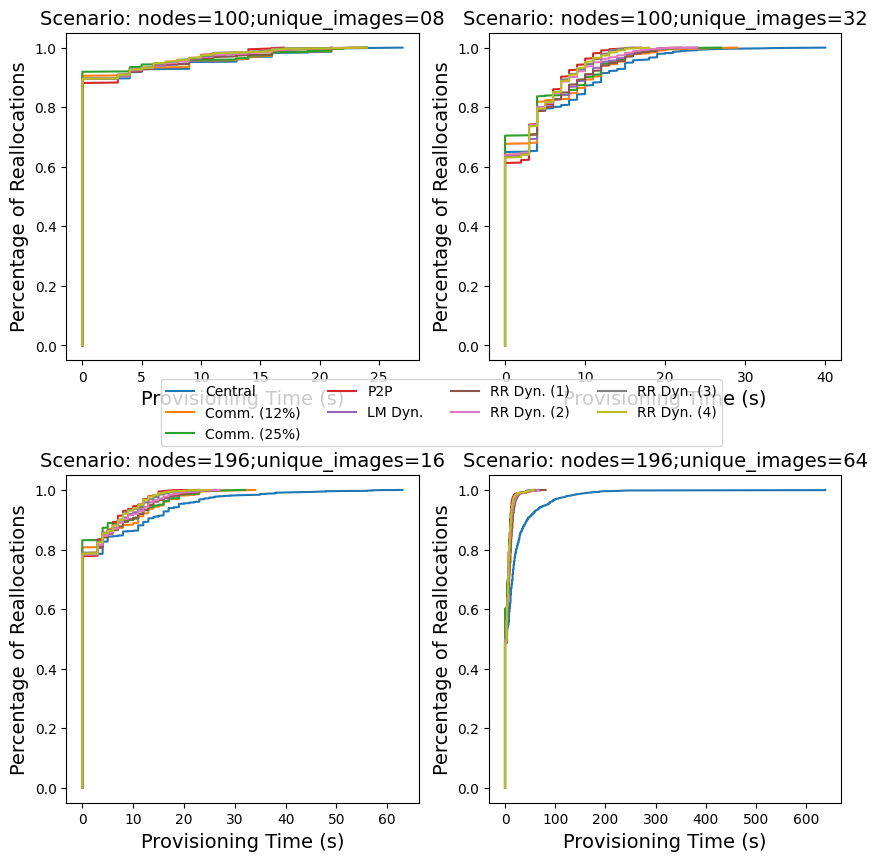

In [23]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))#, sharex=True, sharey=True)

for counter, (key, provisioning_time_df) in enumerate(provisioning_time_dfs.items()):
    provisioning_time_df["Prov. Time Values"] = provisioning_time_df["Prov. Time Values"].apply(lambda x: sorted(x))
    for index, row in provisioning_time_df.iterrows():
        ax[counter // 2][counter % 2].plot(row["Prov. Time Values"], np.linspace(0, 1, len(row["Prov. Time Values"])))
        customize_chart(
            ax[counter // 2][counter % 2],
            xlabel={"xlabel":"Provisioning Time (s)", "fontdict": font_dict},
            ylabel={"ylabel":"Percentage of Reallocations", "fontdict": font_dict},
            title={"label":f"Scenario: {key}", "fontdict": font_dict}
        )

fig.legend(algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.35)

plt.savefig(f"{base_dir}/provisioning_time.pdf", bbox_inches='tight')

### Service Reallocations

In [24]:
reallocations_dfs = {
    variation: get_reallocations_data(last_step, variation)
    for variation in variations
}

#### Stacked Bar Chart

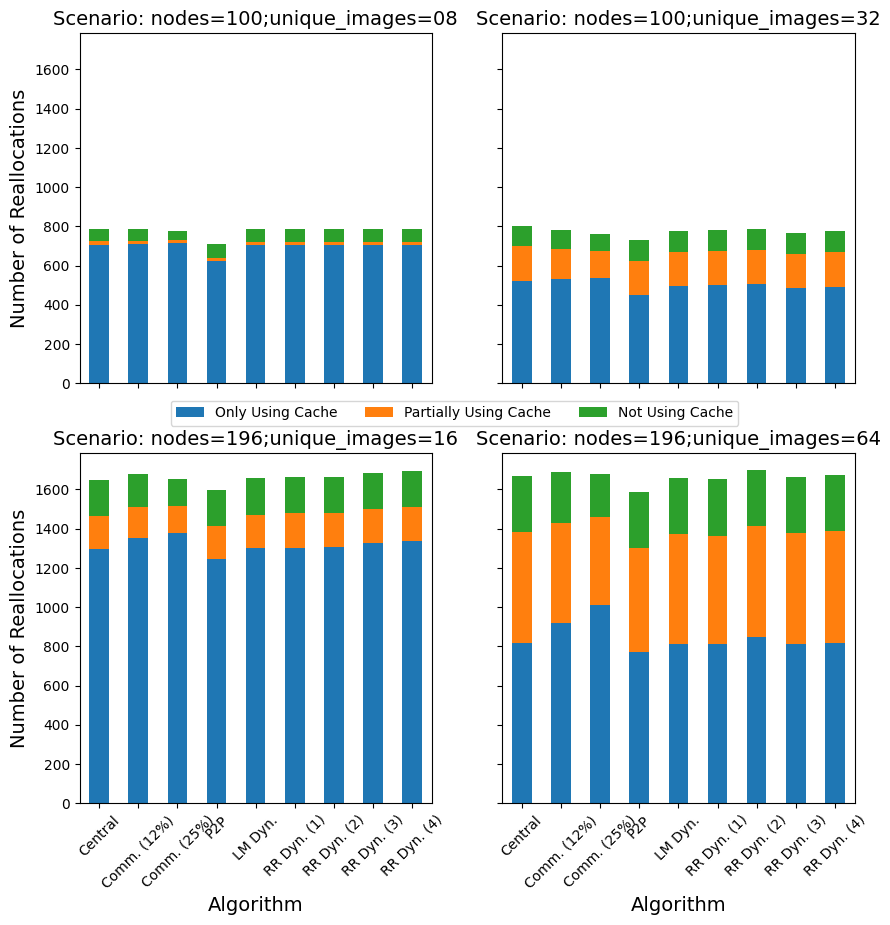

In [25]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, reallocations_df) in enumerate(reallocations_dfs.items()):
    reallocations_df = reallocations_df[["Algorithm", "Only Using Cache", "Partially Using Cache", "Not Using Cache"]]
    reallocations_df.plot.bar(x="Algorithm", stacked=True, ax=ax[counter // 2][counter % 2], rot=45, legend=False)
    customize_chart(
        ax[counter // 2][counter % 2],
        xticklabels={"labels": algorithm_labels},
        xlabel={"xlabel":"Algorithm","fontdict":font_dict},
        ylabel={"ylabel":"Number of Reallocations","fontdict":font_dict},
        title={"label":f"Scenario: {key}","fontdict":font_dict},
    )

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncols=3, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.2)

plt.savefig(f"{base_dir}/reallocations.pdf", bbox_inches='tight')

# TODO: add labels to the bars (%)

### Registry Usage

In [55]:
# TODO: create a metric to understand with how many replicas the registry usage is better (probably with less)
registry_usage_dfs = {
    variation: get_registry_usage_data(variation)
    for variation in variations
}

#### Boxplot Chart (All Registries)

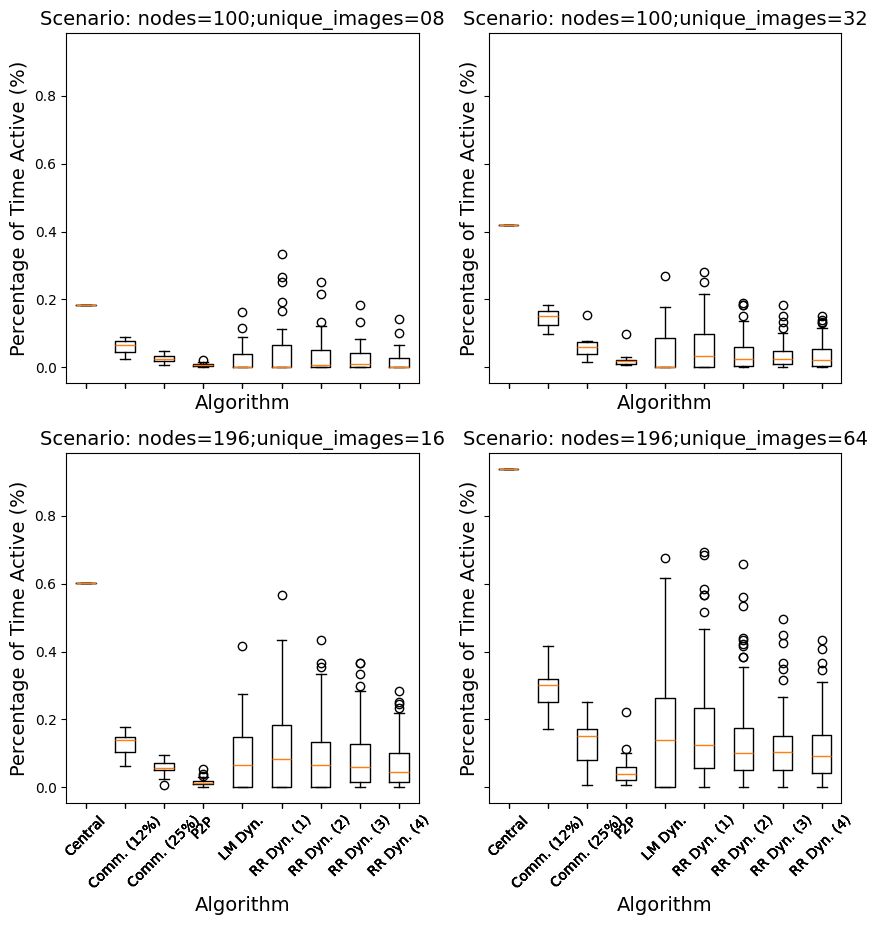

In [27]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, registry_usage_df) in enumerate(registry_usage_dfs.items()):
    registry_usage_df = registry_usage_df[["Algorithm", "Values"]]
    ax[counter // 2][counter % 2].boxplot(registry_usage_df["Values"], labels=algorithm_labels)
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel={"xlabel":"Algorithm","fontdict":font_dict},
        ylabel={"ylabel":"Percentage of Time Active (%)","fontdict":font_dict},
        title={"label":f"Scenario: {key}","fontdict":font_dict},
    )
    for tick in ax[counter // 2][counter % 2].get_xticklabels():
        tick.set_rotation(45)

plt.savefig(f"{base_dir}/registry_usage.pdf", bbox_inches='tight')

# TODO: customize outliers

#### Boxplot Chart (Only Registries with Some Activity)

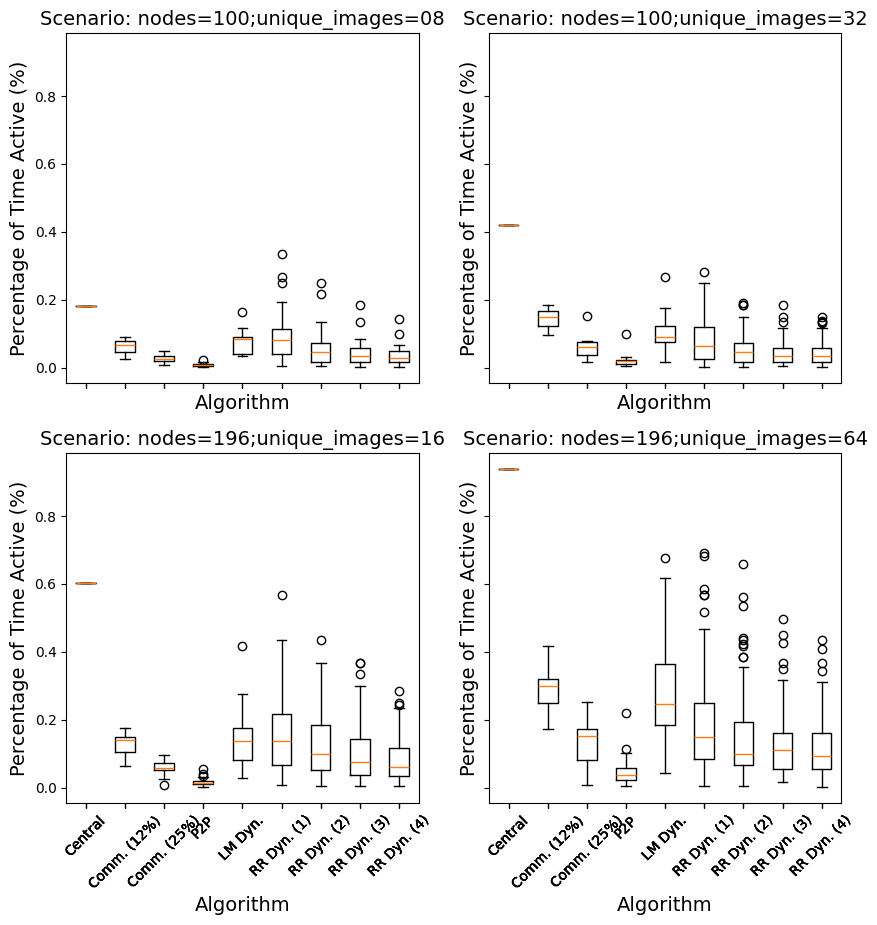

In [28]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, registry_usage_df) in enumerate(registry_usage_dfs.items()):
    registry_usage_df = registry_usage_df[["Algorithm", "Values (w/o 0%)"]]
    ax[counter // 2][counter % 2].boxplot(registry_usage_df["Values (w/o 0%)"], labels=algorithm_labels)
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel={"xlabel":"Algorithm","fontdict":font_dict},
        ylabel={"ylabel":"Percentage of Time Active (%)","fontdict":font_dict},
        title={"label":f"Scenario: {key}","fontdict":font_dict},
    )
    for tick in ax[counter // 2][counter % 2].get_xticklabels():
        tick.set_rotation(45)

plt.savefig(f"{base_dir}/registry_usage_without_0.pdf", bbox_inches='tight')

# TODO: customize outliers

### Number of Registries per Time Step

In [56]:
number_of_registries_dfs = {
    variation: get_number_of_registries_data(variation)
    for variation in variations
}

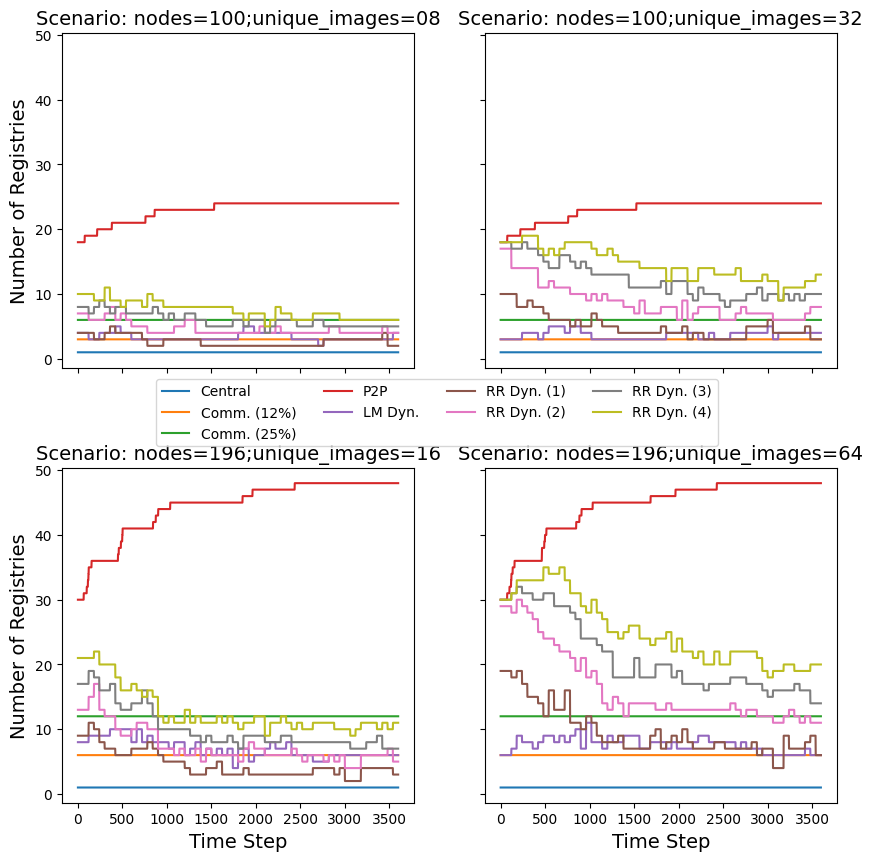

In [30]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, number_of_registries_df) in enumerate(number_of_registries_dfs.items()):
    number_of_registries_df.plot(ax=ax[counter // 2][counter % 2], legend=False)
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel={"xlabel":"Time Step","fontdict":font_dict},
        ylabel={"ylabel":"Number of Registries","fontdict":font_dict},
        title={"label":f"Scenario: {key}","fontdict":font_dict},
    )

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/number_of_registries.pdf", bbox_inches='tight')

### Server Utilization per Time Step

In [31]:
server_utilization_dfs = {
    variation: get_server_utilization_data(variation)
    for variation in variations
}

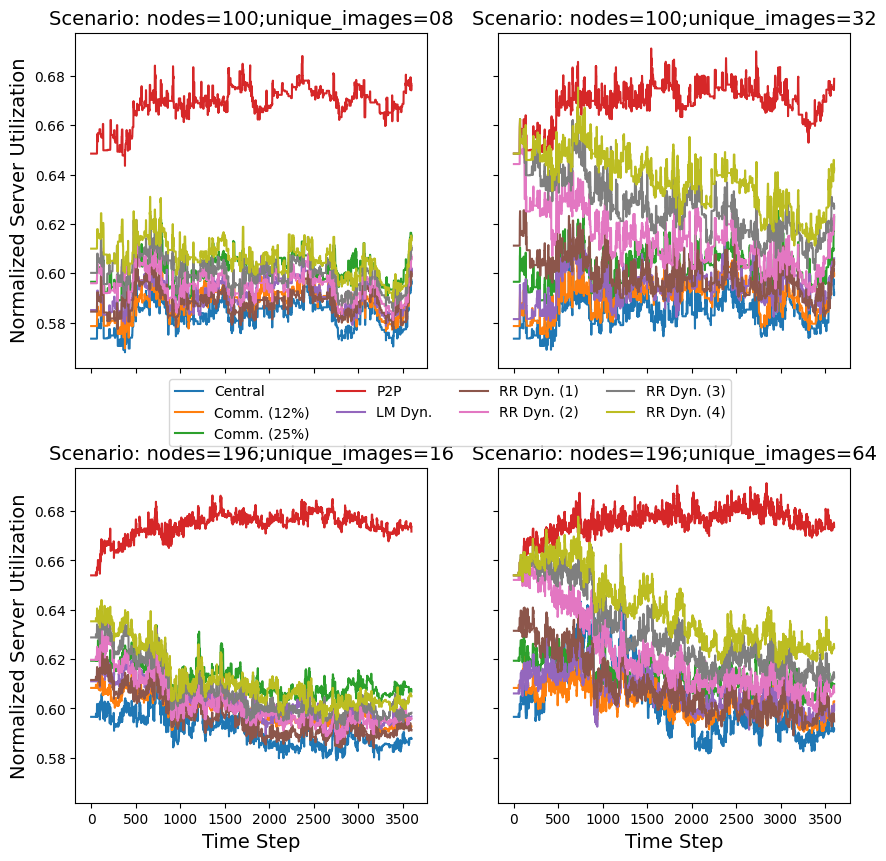

In [32]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, server_utilization_df) in enumerate(server_utilization_dfs.items()):
    server_utilization_df.plot(ax=ax[counter // 2][counter % 2], legend=False)
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel={"xlabel":"Time Step","fontdict":font_dict},
        ylabel={"ylabel":"Normalized Server Utilization","fontdict":font_dict},
        title={"label":f"Scenario: {key}","fontdict":font_dict},
    )

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/server_utilization.pdf", bbox_inches='tight')

### Image replication

In [33]:
target_variation = "nodes=100;unique_images=08"

image_replication_data = [
    get_image_replication_data(log, target_variation) for log in logs[3:]
]

headers = [
    image_replication_data[index].columns.values.tolist() for index in range(len(image_replication_data))
]

max_length = max([len(header) for header in headers])
header_with_max_length = headers[[len(header) for header in headers].index(max_length)]

global_colormap = mpl.colormaps["tab20c"].resampled(max_length)

In [34]:
# TODO: fix when it does not start with zero
headers

[[6,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]

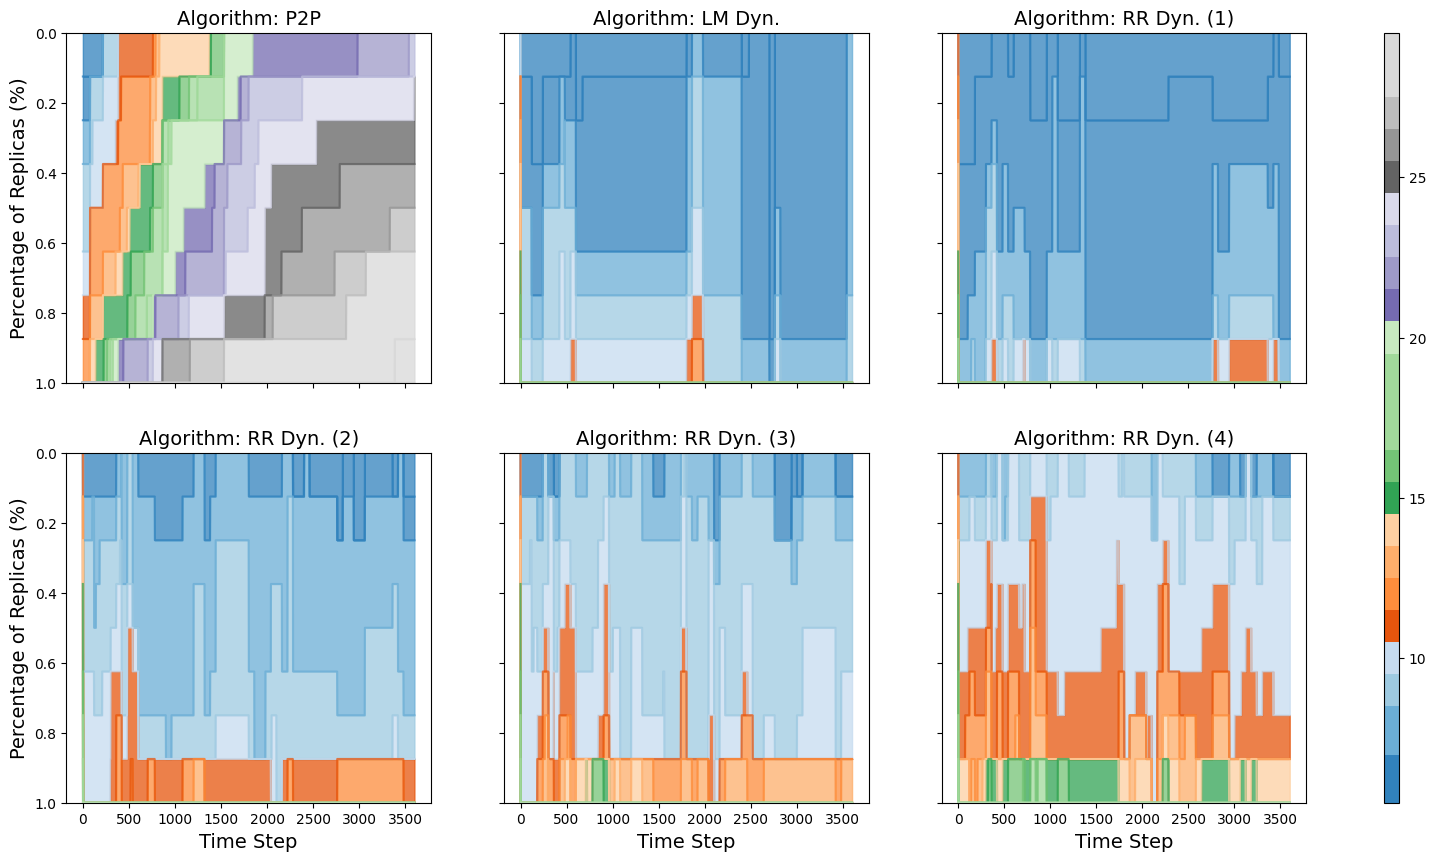

In [35]:
# plot stacked area chart for each algorithm in multiple figures using a single legend
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)

for counter, image_replication_df in enumerate(image_replication_data):
    local_color_map = mpl.colors.ListedColormap(global_colormap.colors[:len(image_replication_df.columns)])
    image_replication_df.plot.area(ax=ax[counter // 3][counter % 3], legend=False, alpha=0.75, cmap=local_color_map)
    ax[counter // 3][counter % 3].set_ylim([0, 1])
    ax[counter // 3][counter % 3].invert_yaxis()
    customize_chart(
        ax[counter // 3][counter % 3],
        xlabel={"xlabel":"Time Step","fontdict":font_dict},
        ylabel={"ylabel":"Percentage of Replicas (%)","fontdict":font_dict},
        title={"label":f"Algorithm: {algorithm_labels[counter+3]}","fontdict":font_dict},
    )

# create a single colorbar for all figures
fig.colorbar(mpl.cm.ScalarMappable(cmap=global_colormap), ax=ax, orientation="vertical", aspect=50, values=header_with_max_length)

plt.savefig(f"{base_dir}/image_replication.pdf", bbox_inches='tight')

### Disk Utilization per Time Step

In [49]:
disk_utilization_dfs = {
    variation: get_disk_utilization_data(variation)
    for variation in variations
}

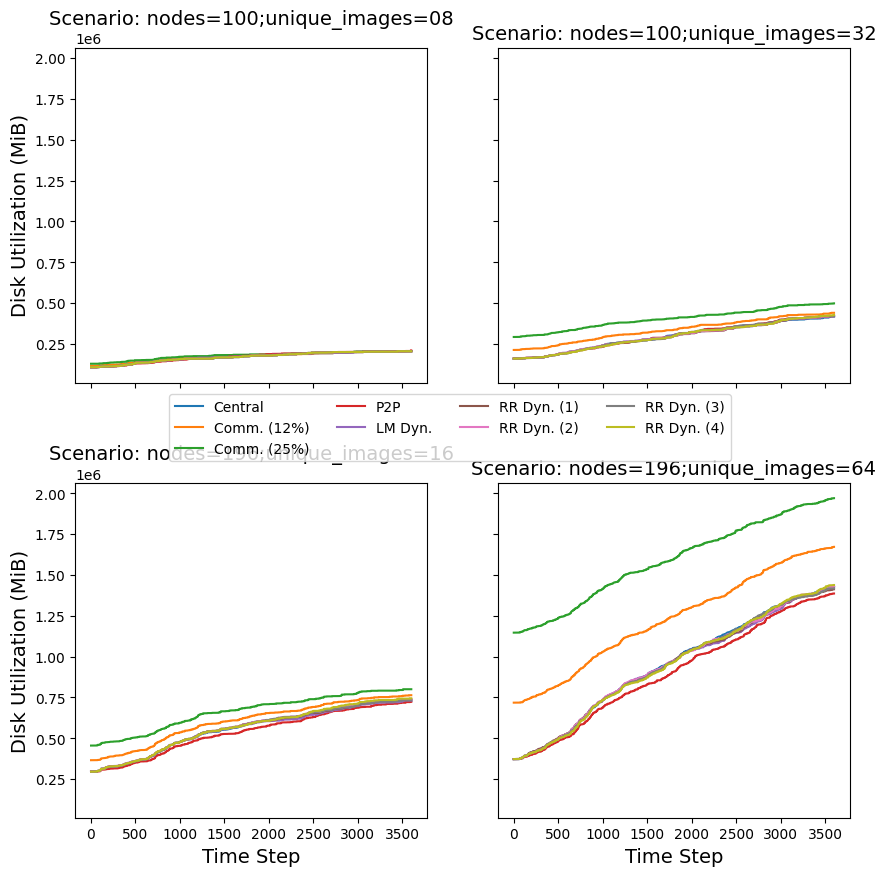

In [50]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, disk_utilization_df) in enumerate(disk_utilization_dfs.items()):
    disk_utilization_df.plot(ax=ax[counter // 2][counter % 2], legend=False)
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel={"xlabel":"Time Step","fontdict":font_dict},
        ylabel={"ylabel":"Disk Utilization (MiB)","fontdict":font_dict},
        title={"label":f"Scenario: {key}","fontdict":font_dict},
    )

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=4, bbox_to_anchor=(0.5, 0.5))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/disk_utilization.pdf", bbox_inches='tight')

### Total Disk Utilization

In [57]:
total_disk_utilization_dfs = {
    variation: get_total_disk_utilization_data(variation)
    for variation in variations
}

### Goals Table

In [77]:
# TODO: use mean values per time step
goals_tables = {}

for key, latency_df in latency_dfs.items():
    #table = latency_df[["Algorithm", "Sum"]] + provisioning_time_dfs[key][["Sum"]] + registry_usage_dfs[key][["Total"]] + total_disk_utilization_dfs[key][["Total Disk Occupation"]]
    table = pd.concat([latency_df[["Algorithm", "Mean"]], provisioning_time_dfs[key][["Mean"]], registry_usage_dfs[key][["Mean Provisioned"]], total_disk_utilization_dfs[key][["Mean Disk Occupation per Server"]]], axis=1)
    #table = table.rename(columns={"Sum": "Latency", "Total": "Registry Usage"})
    #table["Provisioning Time"] = table["Sum"]
    #table = table.drop(columns=["Sum"])
    table.to_csv(f"{base_dir}/goals;{key}.csv", index=False, sep=";", decimal=",")
    goals_tables[key] = table
    
goals_tables_grid = [
    [
        goals_tables[variations[0]].to_latex(index=False, escape=False, column_format="lcccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{nodes=100;unique_images=32} \\\\\n\\toprule"),
        goals_tables[variations[1]].to_latex(index=False, escape=False, column_format="lcccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{nodes=100;unique_images=08} \\\\\n\\toprule"),
    ],
    [
        goals_tables[variations[2]].to_latex(index=False, escape=False, column_format="lcccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{nodes=196;unique_images=64} \\\\\n\\toprule"),
        goals_tables[variations[3]].to_latex(index=False, escape=False, column_format="lcccc", float_format="{:0.2f}".format).replace("\\toprule", "\\toprule\n\multicolumn{5}{c}{ nodes=196;unique_images=16} \\\\\n\\toprule"),
    ]
]

goals_tables_grid_latex_string = create_grid_of_latex_tables(goals_tables_grid, "Goals comparison between algorithms in multiple scenarios.", "tab:goals", "footnotesize", "landscape").replace("%", "\%").replace("_", "\_")

with open(f"{base_dir}/goals_tables.tex", "w") as f:
    f.write(goals_tables_grid_latex_string)